# Recommendations with IBM (Working Version)
## (include extra stuff like: debug, logging, training, experimenting etc)

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [2465]:
import random
from collections import Counter
from pprint import pp

In [775]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [779]:
# 50% of individuals interact with ____ number of articles or fewer.

median_val = df.groupby('email').size().sort_values(ascending=True).median()

median_val

3.0

In [780]:
# The maximum number of user-article interactions by any 1 user is ______. ?

max_views_by_user = df.groupby('email').size().sort_values(ascending=False).head(1).values[0]

max_views_by_user

364

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [781]:
df_content['article_id'].nunique()

1051

In [782]:
# Find and explore duplicate articles

dups = df_content.groupby('article_id').size().sort_values(ascending=False) # duplicates of article id
dups_idx = dups[dups > 1].index # duplicates index

df_content[df_content['article_id'].isin(dups_idx)].sort_values(by='article_id') # retrieve duplicated content

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [783]:
# Remove any rows that have the same article_id - only keep the first

df_content = df_content.drop_duplicates('article_id', keep='first')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [785]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
unique_articles

714

In [786]:
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
total_articles

1051

In [787]:
unique_users = df.email.nunique() # The number of unique users
unique_users


5148

In [788]:
user_article_interactions = df.shape[0] # The number of user-article interactions

user_article_interactions

45993

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [789]:
most_viewed_ds = df.groupby('article_id').size().sort_values(ascending=False).head(1)

In [790]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(most_viewed_ds.index[0])
most_viewed_article_id

'1429.0'

In [791]:
# The most viewed article in the dataset was viewed how many times?

max_views = most_viewed_ds.values[0]
max_views

937

In [792]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [793]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val, 
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions, 
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views, 
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id, 
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles, 
    '`The number of unique users in the dataset is ______`': unique_users, 
    '`The number of unique articles on the IBM platform`': total_articles 
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [794]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    article_ids_ds = df.groupby('article_id').size().sort_values(ascending=False).head(n)
    ids = article_ids_ds.index
    
    top_articles = []
    for i in ids:
        top_articles.append(df[df['article_id'] == i].head(1).title.values[0])
    
    
    
    return top_articles # Return the top article titles from df (not df_content)

In [795]:
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles_ids - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    article_ids_ds = df.groupby('article_id').size().sort_values(ascending=False).head(n)
    ids = article_ids_ds.index
    top_articles_ids = list(ids)
 
    return top_articles_ids # Return the top article ids

In [799]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [800]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [532]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    df_user_item = df.copy()
    
    # Fill in the function here
    df_user_item['title'] = 1
    df_user_item = df_user_item[['user_id', 'article_id', 'title']]
    
    user_item = pd.pivot_table(df_user_item, index='user_id', columns='article_id', values='title', fill_value=0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [533]:
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [534]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


2. Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar). The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.

Use the tests to test your function.

In [873]:
import time

In [697]:
# experiment with pandas inbuilt corr

user_item.loc[(1,2), :].transpose().corr()

user_id,1,2
user_id,,
1,1.000000,0.119027
2,0.119027,1.000000


2. Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar). The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. **Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.**

Use the tests to test your function.

In [1001]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    user_ids_all = user_item.index
    
    # a dictionary holds [user id : similarity] value pairs
    dot_product_dict = {}

    # compute similarity of each user to the provided user
    for i in user_ids_all:
        dot_product = np.dot(user_item.loc[user_id:user_id,:], user_item.loc[i:i,:].transpose())
        dot_product_dict[i] = dot_product[0][0]
        
    # sort by highest (most similar), also drop against self    
    ds = pd.Series(dot_product_dict.values(), index=dot_product_dict.keys()).drop(index=user_id).sort_values(ascending=False)
    
    # extract only index as list of ids. 
    most_similar_users = list(ds.index)
       
    return most_similar_users # return a list of the users in order from most to least similar

In [1004]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [1053]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    
    article_names = []
    
    for id in article_ids:

        name = df[df.article_id == id].title.head(1).values[0]

        article_names.append(name)
    
    return article_names # Return the article names associated with list of article ids


a_ids = [1430.0, 1314.0, 1276.0, 233.0]
get_article_names(a_ids)

['using pixiedust for fast, flexible, and easier data analysis and experimentation',
 'healthcare python streaming application demo',
 'deploy your python model as a restful api',
 'bayesian nonparametric models – stats and bots']

In [1056]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    
    article_ids = list(user_item.loc[user_id][user_item.loc[user_id] > 0].index)
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


get_user_articles(2)

([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0],
 ['using deep learning to reconstruct high-resolution audio',
  'build a python app on the streaming analytics service',
  'gosales transactions for naive bayes model',
  'healthcare python streaming application demo',
  'use r dataframes & ibm watson natural language understanding',
  'use xgboost, scikit-learn & ibm watson machine learning apis'])

In [1185]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    
    # get all similar user ids for the targeted user
    similar_uids = find_similar_users(user_id)


    # get all article ids of the targeted user
    article_ids_target_user = get_user_articles(user_id)[0]
    # print(f"[article_ids_target_user]:\n {article_ids_target_user} \n")

    
    # a list contain unseen articles to recommend
    recs = []

    for uid in similar_uids:

        # print(f"\n\n\n[number of recs]: {len(recs)}\n")
        if len(recs) == m:
            # print(f"Number of recs reaches threadhold. Enough. Stop")
            break


        #print(f"[similar user id]: {uid}")

        # get this uid's article ids, and arbitrarily shuffle
        article_ids_similar_user = get_user_articles(uid)[0]

        # compute the differences of articles seen between the this user and targeted user
        # subtraction's order matters
        set_diff = list(set(article_ids_similar_user) - set(article_ids_target_user))
        # print(f"[set_diff]:\n {set_diff} \n")
        
        # make a shuffle for arbitraily chocies from the diff set
        random.shuffle(set_diff)

        # add the differences of article ids to recs [], append only unique (no duplicate)
        for i in set_diff:
            if i not in recs and len(recs) < m:
                recs.append(i)
                # print(f"[id] {i} appended")

    return recs # return your recommendations for this user_id 

In [1146]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['data tidying in data science experience',
 'this week in data science (april 18, 2017)',
 'shaping data with ibm data refinery',
 'data science platforms are on the rise and ibm is leading the way',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'a tensorflow regression model to predict house values',
 'deep forest: towards an alternative to deep neural networks']

In [3214]:
# According to dataset, df and df_content, article id are all actually numeric. 
# I use numeric id instead of string id for article id, since they are actually all numeric.
# It makes sense to make it consistent numeric over this notebook


print(df.article_id.dtype)
print(df_content.article_id.dtype)

float64
int64


In [1163]:
# Test your functions here
assert set(get_article_names([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320.0, 232.0, 844.0])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320.0, 232.0, 844.0])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [1256]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    # get all neighbors ids
    nbh_ids = find_similar_users(user_id)
    
    
    # assemble a data matrix
    data_matrix = np.array([
    [
        x, # neighbor id
        np.dot(user_item.loc[user_id:user_id,:], user_item.loc[x:x,:].transpose())[0][0], # similarity score
        df[df.user_id == x].shape[0] # number of content interaction
    ] for x in nbh_ids])
    
    # make a dataframe
    neighbors_df = pd.DataFrame(data=data_matrix, 
                                columns=['neighbor_id', 'similarity', 'num_interactions'], 
                                index=data_matrix[:,0]).sort_values(by=['similarity', 'num_interactions'],
                                                                    ascending=[False, False])
    
    
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [1309]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    
    # get all similar user ids for the targeted user
    # fetch with the 'neighbors_df'
    similar_uids = list(get_top_sorted_users(user_id).index)
    #print(f"[similar_uids]: \n{similar_uids}")


    # get all article ids of the targeted user
    article_ids_target_user = get_user_articles(user_id)[0]
    # print(f"[article_ids_target_user]:\n {article_ids_target_user} \n")

    
    # a list contain unseen articles to recommend
    recs = []

    for uid in similar_uids:

        # print(f"\n\n\n[number of recs]: {len(recs)}\n")
        if len(recs) == m:
            #print(f"Number of recs reaches threadhold {m}. Enough. Stop")
            break


        #print(f"[similar user id]: {uid}")

        # get this uid's article ids, and arbitrarily shuffle
        article_ids_similar_user = get_user_articles(uid)[0]

        # compute the differences of articles seen between the this user and targeted user
        # subtraction's order matters
        set_diff = list(set(article_ids_similar_user) - set(article_ids_target_user))
        #print(f"[set_diff before sort]:\n {set_diff} \n")
        
        # Sort the set. Determine with highest total interactions metric 
        set_diff = list(df[df.article_id.isin(set_diff)]['article_id'].value_counts().index)
        #print(f"[set_diff after sort]:\n {set_diff} \n")

        # add the differences of article ids to recs [], append only unique (no duplicate)
        for i in set_diff:
            if i not in recs and len(recs) < m:
                recs.append(i)
                #print(f"[id] {i} appended")
    
    
    
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names






In [1311]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [1312]:
get_top_sorted_users(1).head(1)

,neighbor_id,similarity,num_interactions
3933,3933,35,45


In [1316]:
get_top_sorted_users(131).head(10)

,neighbor_id,similarity,num_interactions
3870,3870,74,144
3782,3782,39,363
23,23,38,364
203,203,33,160
4459,4459,33,158
98,98,29,170
3764,3764,29,169
49,49,29,147
3697,3697,29,145
242,242,25,148


In [1317]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [1318]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


6. If we were given a new user, which of the above functions would you be able to use to make recommendations? Explain. Can you think of a better way we might make recommendations? Use the cell below to explain a better method for new users.

A: For new user, code start problem, we can use knowledge base approach, pulling most-interacted (viewed) content and/or trending content. Since the dataset has no timestamp attribute, we might just pull most-interacted content.

7. Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below. You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [1321]:
new_user = 0.0

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 


new_user_recs = get_top_article_ids(10, df) # Your recommendations here

new_user_recs

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [1322]:
assert set(new_user_recs) == set([1314.0,1429.0,1293.0,1427.0,1162.0,1364.0,1304.0,1170.0,1431.0,1330.0]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [1446]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/apple/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

https://github.com/gilzero/project_disaster_responses/blob/main/train_classifier.py

https://towardsdatascience.com/the-best-document-similarity-algorithm-in-2020-a-beginners-guide-a01b9ef8cf05

In [1358]:
# constants and reusable objects
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [2060]:
df_nlp = df_content.copy()
df_nlp.head(60)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
5,Compose is all about immediacy. You want a new...,Using Compose's PostgreSQL data browser.,Browsing PostgreSQL Data with Compose,Live,5
6,UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...,Upgrading your PostgreSQL deployment to versio...,Upgrading your PostgreSQL to 9.5,Live,6
7,Follow Sign in / Sign up 135 8 * Share\r\n * 1...,For a company like Slack that strives to be as...,Data Wrangling at Slack,Live,7
8,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Live,8
9,THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...,[A version of this post appears on the O’Reill...,Using Apache Spark to predict attack vectors a...,Live,9


In [1431]:
def tokenize(text):
    '''
    private tokenizer to transform each text.
    As a NLP helper function including following tasks:
    - Replace URLs
    - Normalize text
    - Remove punctuation
    - Tokenize words
    - Remove stop words
    - Legmmatize words
    :param text: A message text.
    :return: cleaned tokens extracted from original message text.
    '''

    # print(f"original text: \n {text}")

    # replace urls
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # tokenize text
    tokens = word_tokenize(text)

    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word).strip() for word in tokens if word not in stop_words]

    # in case after normalize/lemmatize, if there is no words, make a dummy element. otherwise StartingVerb breaks
    if len(tokens) < 1:
        tokens = ['none']

    # print(f"tokens: \n {tokens} \n\n")
    return tokens

In [2061]:
# Found index and article id mismatched. Update index with article to make it consistant

df_nlp.index = df_nlp.article_id

In [2062]:
# Cleaning Data. For empty content in body
# There are some rows' doc_body value is NaN
df_nlp.doc_body.isnull()


article_id
0       False
1       False
2       False
3       False
4       False
        ...  
1046    False
1047    False
1048    False
1049     True
1050    False
Name: doc_body, Length: 1051, dtype: bool

In [2063]:
# Update the empty body with 'empty' placeholder
df_nlp.loc[df_nlp[df_nlp.doc_body.isnull()].index, 'doc_body'] = 'empty'

In [2064]:
# Update the empty desc with 'empty' placeholder
# There are some rows' doc_description value is NaN

df_nlp.loc[df_nlp[df_nlp.doc_description.isnull()].index, 'doc_description'] = 'empty'

In [1566]:
def _compute_article_body_similarity(article_id_1, article_id_2):
    # Compute the consine similarity based on tfidf of body content
    # This is a private helper function that is used by overall similarity function.
    

    doc_a = ' '.join(tokenize(df_nlp.loc[article_id_1].doc_body))
    doc_b = ' '.join(tokenize(df_nlp.loc[article_id_2].doc_body))
    
    

    # combine to a list of documents
    documents = [doc_a, doc_b]

    
    # instanciate a scikitlearn tfidf vecorizer
    vectorizer = TfidfVectorizer()

    # fit transform to get a sparse matrix
    matrix = vectorizer.fit_transform(documents)


    # # UnComment out belows to examing details (term features, tfidf values)
    # ====================================
    # term_features =  vectorizer.get_feature_names_out()

    # # convert to readable array 
    # matrix_array = matrix.toarray()

    # # assemble to a dataframe for explor 
    # tfidf_dataframe = pd.DataFrame(data=matrix_array, columns=term_features)
    # ====================================


    return cosine_similarity(matrix[:1], matrix[1:])[0][0]

In [1567]:
def _compute_article_title_similarity(article_id_1, article_id_2):
    # Compute the consine similarity based on tfidf of title (doc_full_name)
    # think of title tag for seo pagerank
    
    # This is a private helper function that is used by overall similarity function.
    

    doc_a = ' '.join(tokenize(df_nlp.loc[article_id_1].doc_full_name))
    doc_b = ' '.join(tokenize(df_nlp.loc[article_id_2].doc_full_name))
    
    

    # combine to a list of documents
    documents = [doc_a, doc_b]

    
    # instanciate a scikitlearn tfidf vecorizer
    vectorizer = TfidfVectorizer()

    # fit transform to get a sparse matrix
    matrix = vectorizer.fit_transform(documents)


    # # UnComment out belows to examing details (term features, tfidf values)
    # ====================================
    # term_features =  vectorizer.get_feature_names_out()

    # # convert to readable array 
    # matrix_array = matrix.toarray()

    # # assemble to a dataframe for explor 
    # tfidf_dataframe = pd.DataFrame(data=matrix_array, columns=term_features)
    # ====================================


    return cosine_similarity(matrix[:1], matrix[1:])[0][0]

In [1568]:
def _compute_article_desc_similarity(article_id_1, article_id_2):
    # Compute the consine similarity based on tfidf of desc content (doc_description)
    # think of desc tag for seo pagerank
    
    # This is a private helper function that is used by overall similarity function.
    

    doc_a = ' '.join(tokenize(df_nlp.loc[article_id_1].doc_description))
    doc_b = ' '.join(tokenize(df_nlp.loc[article_id_2].doc_description))
    
    

    # combine to a list of documents
    documents = [doc_a, doc_b]

    
    # instanciate a scikitlearn tfidf vecorizer
    vectorizer = TfidfVectorizer()

    # fit transform to get a sparse matrix
    matrix = vectorizer.fit_transform(documents)


    # # UnComment out belows to examing details (term features, tfidf values)
    # ====================================
    # term_features =  vectorizer.get_feature_names_out()

    # # convert to readable array 
    # matrix_array = matrix.toarray()

    # # assemble to a dataframe for explor 
    # tfidf_dataframe = pd.DataFrame(data=matrix_array, columns=term_features)
    # ====================================


    return cosine_similarity(matrix[:1], matrix[1:])[0][0]

In [1571]:
def compute_article_similarity(article_id_1, article_id_2):
    # calculate similary for body, title, desc, then combine a single value.
    # think about how google weight. Title tag is very heavy. SEO-wised
    # so having 3 consine similarity values, then do a normailized one. 
    # what's the formular? think of a course, assignments weight x, final exam weight y,
    # then what's total grade.
    # https://www.indeed.com/career-advice/career-development/how-to-calculate-weighted-average
    
    similarity_title = _compute_article_title_similarity(article_id_1,article_id_2)
    similarity_body = _compute_article_body_similarity(article_id_1,article_id_2)
    similarity_desc = _compute_article_desc_similarity(article_id_1,article_id_2)
    
    # a weighted sum caluculation for final score
    
    overall = similarity_title * 0.5 + similarity_body * 0.4 + similarity_desc * 0.1
    
    return overall


In [1576]:
compute_article_similarity(55,50)

0.07122043497708203

In [1794]:
# Find similar articles for a given article.
# This only work on df_content/df_nlp dataset. 
# Use full details of a article. (title, desc, body), these info only available in df_content/df_nlp dataset
# Calculate in real time, it might take some times
# (since it loop to all articles against the targeted article, use consine similarity not dot product.)
# For articles that not in df_content dataset, another 
# method is suitable loopup_similar_title_articles(), it checks only on title. 


def find_similar_articles(article_id, data=df_nlp):
    
    article_ids_all = data.index
    similarity_dict = {}
    
    for i in article_ids_all:
        # print(f"\n[i]: {i}")
        
        if i == article_id:
            continue

        similarity_score = compute_article_similarity(article_id,i)
        similarity_dict[i] = similarity_score
        # print(f"[similarity_score]: {similarity_score}")
    
    
    similarity_ds = pd.Series(data=similarity_dict.values(), 
                           index=similarity_dict.keys()).sort_values(ascending=False).index
    
    return list(similarity_ds)


In [2594]:
# Calculate in real time, it might take some seconds
# (since it loop to all articles against the targeted article, use consine similarity not dot product.)

relavant_articles = find_similar_articles(420)

relavant_articles[:20]

[389,
 993,
 949,
 592,
 714,
 117,
 678,
 942,
 231,
 925,
 15,
 463,
 353,
 835,
 907,
 284,
 977,
 600,
 595,
 997]

In [1663]:
# Checking relavancy. They are order by relavancy. 

df_nlp.iloc[relavant_articles].head(20)

# Looks like related to 'Apache Spark'

,doc_body,doc_description,doc_full_name,doc_status,article_id
article_id,,,,,
389,* Home\r\n * Community\r\n * Projects\r\n * Bl...,What a difference a version number makes! With...,Apache Spark™ 2.0: Impressive Improvements to ...,Live,389
993,* Home\r\n * Community\r\n * Projects\r\n * Bl...,The Apache Spark website documents the propert...,Configuring the Apache Spark SQL Context,Live,993
949,* Home\r\n * Community\r\n * Projects\r\n * Bl...,The Apache Spark SQL component has several sub...,Apache Spark SQL Analyzer Resolves Order-by Co...,Live,949
592,APACHE SPARK ANALYTICSCombine Apache® Spark™ w...,Combine Apache® Spark™ with other cloud servic...,Apache Spark Analytics,Live,592
714,* Home\r\n * Community\r\n * Projects\r\n * Bl...,From the big crop of books about Apache Spark™...,A Survey of Books about Apache Spark™,Live,714
117,* Home\r\n * Community\r\n * Projects\r\n * Bl...,This post provides a brief summary of sample c...,Apache Spark™ 2.0: Migrating Applications,Live,117
678,{ spark .tc } * Community\r\n * Projects\r\n *...,Spark SQL Version 1.6 runs queries faster! Tha...,Spark SQL - Rapid Performance Evolution,Live,678
942,* Home\r\n * Community\r\n * Projects\r\n * Bl...,Sean looks back on his first encounter with Sp...,"Interview with Sean Li, New Apache Spark™ Comm...",Live,942
231,Skip to main content IBM developerWorks / Deve...,Get faster queries and write less code too. Le...,Speed your SQL Queries with Spark SQL,Live,231


The above find_similar_articles work well, however it is calculating on the fly, could take time to load, for user experience, real time calculating too expensive. So make a article_article_similary dataframe for look up. (the content-content rec). This can be act as, people view X article also might be interested in Y article based on relavancy.

### Approach:
Make a dataframe, store article-article-similarity.
(Based on the cleaned df_content version dataset: df_nlp)


In [1673]:
# Make a article_article dummy dataframe based on shape of df_nlp

article_article = pd.DataFrame(
                data=np.zeros((len(df_nlp.index),len(df_nlp.index))), 
                index=df_nlp.index, 
                columns=df_nlp.index
            )

article_article

article_id,0,1,2,3,4,5,6,7,8,9,...,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050
article_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1692]:
# Iterations. Update the similar score values to article_article

# ATTENTION: THE ITERATION TAKES time, better to track progress


start = time.time()


# Number of articles
len_articles = article_article.shape[0]

# List of index of articles
idx_articles = list(article_article.index)


# Loop thru each article: for each row, loop each columns. 
for i in idx_articles:
    print(f"Processing row {i} of {len_articles-1}.")
    
    for j in idx_articles:
        article_article.loc[i, j] = compute_article_similarity(i, j)
        

end = time.time()
print(end - start)

Processing row 0 of 1050.
Processing row 1 of 1050.
Processing row 2 of 1050.
Processing row 3 of 1050.
Processing row 4 of 1050.
Processing row 5 of 1050.
Processing row 6 of 1050.
Processing row 7 of 1050.
Processing row 8 of 1050.
Processing row 9 of 1050.
Processing row 10 of 1050.
Processing row 11 of 1050.
Processing row 12 of 1050.
Processing row 13 of 1050.
Processing row 14 of 1050.
Processing row 15 of 1050.
Processing row 16 of 1050.
Processing row 17 of 1050.
Processing row 18 of 1050.
Processing row 19 of 1050.
Processing row 20 of 1050.
Processing row 21 of 1050.
Processing row 22 of 1050.
Processing row 23 of 1050.
Processing row 24 of 1050.
Processing row 25 of 1050.
Processing row 26 of 1050.
Processing row 27 of 1050.
Processing row 28 of 1050.
Processing row 29 of 1050.
Processing row 30 of 1050.
Processing row 31 of 1050.
Processing row 32 of 1050.
Processing row 33 of 1050.
Processing row 34 of 1050.
Processing row 35 of 1050.
Processing row 36 of 1050.
Processing 

Processing row 297 of 1050.
Processing row 298 of 1050.
Processing row 299 of 1050.
Processing row 300 of 1050.
Processing row 301 of 1050.
Processing row 302 of 1050.
Processing row 303 of 1050.
Processing row 304 of 1050.
Processing row 305 of 1050.
Processing row 306 of 1050.
Processing row 307 of 1050.
Processing row 308 of 1050.
Processing row 309 of 1050.
Processing row 310 of 1050.
Processing row 311 of 1050.
Processing row 312 of 1050.
Processing row 313 of 1050.
Processing row 314 of 1050.
Processing row 315 of 1050.
Processing row 316 of 1050.
Processing row 317 of 1050.
Processing row 318 of 1050.
Processing row 319 of 1050.
Processing row 320 of 1050.
Processing row 321 of 1050.
Processing row 322 of 1050.
Processing row 323 of 1050.
Processing row 324 of 1050.
Processing row 325 of 1050.
Processing row 326 of 1050.
Processing row 327 of 1050.
Processing row 328 of 1050.
Processing row 329 of 1050.
Processing row 330 of 1050.
Processing row 331 of 1050.
Processing row 332 o

Processing row 590 of 1050.
Processing row 591 of 1050.
Processing row 592 of 1050.
Processing row 593 of 1050.
Processing row 594 of 1050.
Processing row 595 of 1050.
Processing row 596 of 1050.
Processing row 597 of 1050.
Processing row 598 of 1050.
Processing row 599 of 1050.
Processing row 600 of 1050.
Processing row 601 of 1050.
Processing row 602 of 1050.
Processing row 603 of 1050.
Processing row 604 of 1050.
Processing row 605 of 1050.
Processing row 606 of 1050.
Processing row 607 of 1050.
Processing row 608 of 1050.
Processing row 609 of 1050.
Processing row 610 of 1050.
Processing row 611 of 1050.
Processing row 612 of 1050.
Processing row 613 of 1050.
Processing row 614 of 1050.
Processing row 615 of 1050.
Processing row 616 of 1050.
Processing row 617 of 1050.
Processing row 618 of 1050.
Processing row 619 of 1050.
Processing row 620 of 1050.
Processing row 621 of 1050.
Processing row 622 of 1050.
Processing row 623 of 1050.
Processing row 624 of 1050.
Processing row 625 o

Processing row 883 of 1050.
Processing row 884 of 1050.
Processing row 885 of 1050.
Processing row 886 of 1050.
Processing row 887 of 1050.
Processing row 888 of 1050.
Processing row 889 of 1050.
Processing row 890 of 1050.
Processing row 891 of 1050.
Processing row 892 of 1050.
Processing row 893 of 1050.
Processing row 894 of 1050.
Processing row 895 of 1050.
Processing row 896 of 1050.
Processing row 897 of 1050.
Processing row 898 of 1050.
Processing row 899 of 1050.
Processing row 900 of 1050.
Processing row 901 of 1050.
Processing row 902 of 1050.
Processing row 903 of 1050.
Processing row 904 of 1050.
Processing row 905 of 1050.
Processing row 906 of 1050.
Processing row 907 of 1050.
Processing row 908 of 1050.
Processing row 909 of 1050.
Processing row 910 of 1050.
Processing row 911 of 1050.
Processing row 912 of 1050.
Processing row 913 of 1050.
Processing row 914 of 1050.
Processing row 915 of 1050.
Processing row 916 of 1050.
Processing row 917 of 1050.
Processing row 918 o

In [1694]:
# Check updated article_article with calculated results. 

article_article

article_id,0,1,2,3,4,5,6,7,8,9,...,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050
article_id,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.032471,0.072460,0.020439,0.259333,0.033410,0.016156,0.051355,0.046419,0.047824,...,0.063201,0.051671,0.143709,0.020163,0.010646,0.003492,0.004095,0.028436,0.000000,0.078722
1,0.032471,1.000000,0.186967,0.028671,0.093232,0.098205,0.035012,0.155317,0.206362,0.103742,...,0.104562,0.152361,0.093032,0.030101,0.082490,0.014128,0.019350,0.056505,0.010927,0.090637
2,0.072460,0.186967,1.000000,0.053018,0.172458,0.106455,0.041646,0.204603,0.339824,0.153497,...,0.149979,0.208527,0.139453,0.036274,0.009098,0.009416,0.013930,0.104403,0.018914,0.160396
3,0.020439,0.028671,0.053018,1.000000,0.027609,0.037732,0.084109,0.048761,0.031276,0.049991,...,0.027299,0.026927,0.033499,0.010938,0.036107,0.012851,0.011922,0.010652,0.009425,0.036531
4,0.259333,0.093232,0.172458,0.027609,1.000000,0.095990,0.026990,0.154261,0.135846,0.152328,...,0.122135,0.141956,0.137278,0.024670,0.007071,0.006955,0.003037,0.038724,0.072108,0.138237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,0.003492,0.014128,0.009416,0.012851,0.006955,0.019682,0.009555,0.018015,0.004764,0.006668,...,0.013567,0.003230,0.003622,0.014652,0.005776,1.000000,0.000000,0.001758,0.000000,0.005407
1047,0.004095,0.019350,0.013930,0.011922,0.003037,0.010529,0.002925,0.006396,0.007393,0.017164,...,0.007295,0.002512,0.005704,0.001240,0.006689,0.000000,1.000000,0.058308,0.000000,0.006413
1048,0.028436,0.056505,0.104403,0.010652,0.038724,0.026182,0.017823,0.050228,0.041883,0.069507,...,0.074214,0.024484,0.034961,0.020447,0.015387,0.001758,0.058308,1.000000,0.000000,0.114996


In [1695]:
# Export to pickle

article_article.to_pickle('article_article_similarity_df.pkl')

In [2261]:
1427 in article_article.index.values

False

In [2284]:
# Instead of finding in real time. Use a query method from pre-calculated 
# article_article df. Save time.

def loopup_similar_articles(article_id, data=article_article, n=20):
    
    # input: n - number of top similar to return
    
    if article_id in article_article.index.values:
    
        ids = list(data.loc[article_id][data.loc[article_id].index != article_id].sort_values(ascending=False).head(n).index)
        names = list(df_nlp.loc[ids].doc_full_name.values)
        
    else:
        # print(f"[article_id] {article_id} not found in df_content")
        ids = []
        names = []
    
    
    return ids, names


In [1785]:
# Test result: look up most relavant articles for 455th article

relavant_for_455th_article = loopup_similar_articles(455, n=30)
relavant_for_455th_article

# Revealing that they are about on 'machine learning'.

([800,
  1035,
  313,
  805,
  444,
  721,
  260,
  967,
  122,
  96,
  384,
  809,
  124,
  723,
  234,
  892,
  54,
  253,
  812,
  861,
  412,
  732,
  871,
  74,
  221,
  89,
  479,
  616,
  500,
  567],
 ['Machine Learning for the Enterprise',
  'Machine Learning for the Enterprise.',
  'What is machine learning?',
  'Machine Learning for everyone',
  'Declarative Machine Learning',
  'The power of machine learning in Spark',
  'The Machine Learning Database',
  'ML Algorithm != Learning Machine',
  'Watson Machine Learning for Developers',
  'Improving quality of life with Spark-empowered machine learning',
  'Continuous Learning on Watson',
  'Use the Machine Learning Library',
  'Python Machine Learning: Scikit-Learn Tutorial',
  '10 Essential Algorithms For Machine Learning Engineers',
  '3 Scenarios for Machine Learning on Multicloud',
  'Breaking the 80/20 rule: How data catalogs transform data scientists’ productivity',
  '8 ways to turn data into value with Apache Spark ma

### Note on datasets inconsistency: 

Since that orginal df_content / df_nlp (cleaned version) only contain article from \[0 - 1050\].

However, df (the interaction) dataset showing more article ids that beyone 1050. e,g 1429.

So these two dataset's article are not up to dated.  
The given df_content is 'late' (not catch up), which means: **articles that are in df (interaction) dataset might 
not be found in df_content dataset**. 

Therefore, due to this inconsistency, we will not be able to find content details for some articles mentioned in df.

----


### Other ideas to explore: 
- Based on the relavant article for a given article, can you get common words on them. Extract topic perhaps
- What are the top contents? (that also in df_content/df_nlp)
- What are the common words / terms of those top content? word bag counter
- Can these words/terms represent trending topic?
- Make a list of most trending topics


In [1984]:
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten

In [2001]:
# helper function: get two grams

def get_bigrams_by_article_id(id):
    title = df_nlp.loc[id].doc_full_name
    desc = df_nlp.loc[id].doc_description
    body = df_nlp.loc[id].doc_body
    
    # a list of tokens
    tokened_text = tokenize(title) + tokenize(desc) + tokenize(body)
    
    # ngrams 2
    grams = [f"{x[0]} {x[1]}" for x in list(bigrams(tokened_text))]
    
    # sort with frequency descending
    sorted_grams = [x[0] for x in Counter(grams).most_common()]
    
    return sorted_grams

In [2002]:
get_bigrams_by_article_id(949)

['logical plan',
 'apache spark',
 'spark sql',
 'c 3',
 'sort operator',
 'parsed logical',
 'make sure',
 'community project',
 'project blog',
 'spark spark',
 'aggregate operator',
 'a1 14',
 'a2 15',
 'sql analyzer',
 'analyzer resolve',
 'resolve order',
 'order column',
 'column apache',
 'sql component',
 'component several',
 'several sub',
 'sub component',
 'component including',
 'including analyzer',
 'analyzer play',
 'play important',
 'important role',
 'role making',
 'making sure',
 'sure logical',
 'plan fully',
 'fully resolved',
 'resolved end',
 'end analysis',
 'analysis phase',
 'phase analyzer',
 'analyzer take',
 'take parsed',
 'plan input',
 'input make',
 'sure table',
 'table reference',
 'reference attribute',
 'attribute column',
 'column reference',
 'reference function',
 'function reference',
 'reference resolved',
 'resolved looking',
 'looking metadata',
 'metadata catalog',
 'catalog work',
 'work applying',
 'applying set',
 'set rule',
 'rule log

In [2004]:
# Extract possible topics (terms) for a given article.
# Algorithm explain:
# - Fetch highly relevant articles
# - Get each article's ngrams results
# - Union the ngrams, find intersection terms from these relevant articles.
# Since relevant similarity score is calculated with TFIDF (term frequency),
# so the more relevant, the more highly possible to have intersected ngrams terms.

def extract_topics_bigrams_by_article_id(article_id, m=3):
    
    # m: threadhold of how many most relevant articles to look for
    # (generally, the more instances to union, the less likely to have intersection, 
    # so don't set m too large.)
    
    
    # Get relavant articles ids. (also append self)
    ids = [article_id] + loopup_similar_articles(article_id)[0][:m]
    
    # Get ngrams for each article, and assemble to documents list. 
    documents = [get_bigrams_by_article_id(i) for i in ids]
    
    
    # Find intersected. 
    # Since np.intersect1d only take two instances, use reduce() to
    # do 'batch' processing iteration. 
    topics = functools.reduce(lambda x, y: np.intersect1d(x, y), documents)
    
    return topics

In [2008]:
# Test the result: 

extract_topics_bigrams_by_article_id(788, m=3)

array(['machine learning'], dtype='<U52')

In [2014]:
# Test the result: 

extract_topics_bigrams_by_article_id(1047, m=3)

array(['logistic regression'], dtype='<U29')

In [2020]:
# Check topic extracted against articles

loopup_similar_articles(1047)[1]

['How to Perform a Logistic Regression in R',
 'Build a logistic regression model with WML & DSX',
 'Higher-order Logistic Regression for Large Datasets',
 'Build a Naive-Bayes Model with WML & DSX',
 'Simple Linear Regression? Do It The Bayesian Way',
 'Empirical Bayes for multiple sample sizes',
 'Modern Machine Learning Algorithms',
 'Understanding empirical Bayes estimation (using baseball statistics)',
 'Ensemble Learning to Improve Machine Learning Results',
 'Which One to Choose for Your Problem',
 'Top 10 Machine Learning Algorithms for Beginners',
 'What I Learned Implementing a Classifier from Scratch in Python · Jean-Nicholas Hould',
 'Essentials of Machine Learning Algorithms (with Python and R Codes)',
 '10 Essential Algorithms For Machine Learning Engineers',
 'Deep Learning Achievements Over the Past Year ',
 'ML Algorithm != Learning Machine',
 'Learn TensorFlow and Deep Learning Together and Now!',
 'Dimensionality Reduction Algorithms',
 'Best Practices for Custom Mod

----

In [2052]:
# What are the most viewed (popular) articles? 

def get_most_popular_articles(data=df, n=10):
    # input: n - number of top viewed to return
    
    ids = data.groupby('article_id').size().sort_values(ascending=False).head(n).index
    
    return list(ids.values)
    



In [2053]:
most_popular_list = list(get_most_popular_articles(n=20))
most_popular_list

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0,
 1436.0,
 1271.0,
 1398.0,
 43.0,
 1351.0,
 1393.0,
 1185.0,
 1160.0,
 1354.0,
 1368.0]

In [2056]:
df[df.article_id.isin(most_popular_list)].title.value_counts()

use deep learning for image classification                            937
insights from new york car accident reports                           927
visualize car data with brunel                                        671
use xgboost, scikit-learn & ibm watson machine learning apis          643
predicting churn with the spss random tree algorithm                  627
healthcare python streaming application demo                          614
finding optimal locations of new store using decision optimization    572
apache spark lab, part 1: basic concepts                              565
analyze energy consumption in buildings                               512
gosales transactions for logistic regression model                    483
welcome to pixiedust                                                  481
customer demographics and sales                                       473
total population by country                                           465
deep learning with tensorflow course b

----

### Approach
Deal with limit info of article in df. And inconsistent article instance in df, df_content.


In [2595]:
unique_ids_in_df = sorted(list(df.article_id.astype('int64').value_counts().index))



In [2596]:
unique_ids_in_df_content = sorted(list(df_content.article_id.astype('int64').value_counts().index))


In [2597]:
# ids that are not in df_content, but appear in df

ids_not_in_df_content = list(set(unique_ids_in_df) - set(unique_ids_in_df_content))


In [2098]:
# There are 277 articles that mentioned in df, but not shown in df_content. 
# (inconsistency: the given df_content is not up to date)
# For these 277 articles, we only have 'page title' information. 

len(ids_not_in_df_content)

277

In [2144]:
# Subset the diff articles dataframe

ids_not_in_df_content_float = [float(x) for x in ids_not_in_df_content]

df_diff = df[df.article_id.isin(ids_not_in_df_content_float)][['article_id', 'title']].drop_duplicates()

df_diff.article_id = df_diff.article_id.astype('int64')

df_diff = df_diff.sort_values(by='article_id', ascending=True)

df_diff.index = df_diff.article_id.values.flatten()

df_diff

,article_id,title
1051,1051,a tensorflow regression model to predict house...
1052,1052,access db2 warehouse on cloud and db2 with python
1053,1053,access mysql with python
1054,1054,access mysql with r
1055,1055,access postgresql with python
...,...,...
1440,1440,world marriage data
1441,1441,world tourism data by the world tourism organi...
1442,1442,worldwide county and region - national account...
1443,1443,worldwide electricity demand and production 19...


**As these diff articles only have title info, we can build a title-title similary model based on TFIDF of title-title**

In [2143]:
df_content_titles_subset = df_content[['article_id', 'doc_full_name']]

df_content_titles_subset.columns = [['article_id', 'title']]

df_content_titles_subset.index = df_content_titles_subset['article_id'].values.flatten()

df_content_titles_subset

,article_id,title
0,0,Detect Malfunctioning IoT Sensors with Streami...
1,1,Communicating data science: A guide to present...
2,2,"This Week in Data Science (April 18, 2017)"
3,3,DataLayer Conference: Boost the performance of...
4,4,Analyze NY Restaurant data using Spark in DSX
...,...,...
1046,1046,A look under the covers of PouchDB-find
1047,1047,A comparison of logistic regression and naive ...
1048,1048,What I Learned Implementing a Classifier from ...
1049,1049,Use dashDB with Spark


In [2171]:
a = df_content_titles_subset.to_numpy()

In [2172]:
b = df_diff.to_numpy()

In [2178]:
all_titles_np = np.concatenate((a, b))
all_titles_np

array([[0, 'Detect Malfunctioning IoT Sensors with Streaming Analytics'],
       [1, 'Communicating data science: A guide to presenting your work'],
       [2, 'This Week in Data Science (April 18, 2017)'],
       ...,
       [1442,
        'worldwide county and region - national accounts - gross national income 1948-2010'],
       [1443, 'worldwide electricity demand and production 1990-2012'],
       [1444,
        'worldwide fuel oil consumption by household (in 1000 metric tons)']],
      dtype=object)

In [2180]:
len(all_titles_np)

1328

In [2185]:
titles_df = pd.DataFrame(all_titles_np)
titles_df.columns = ['article_id', 'title']
titles_df.index = titles_df.article_id
titles_df.tail(50)

,article_id,title
article_id,,
1390,1390,style transfer experiments with watson machine...
1391,1391,sudoku
1393,1393,the nurse assignment problem
1394,1394,the nurse assignment problem data
1395,1395,the unit commitment problem
1396,1396,times world university ranking analysis
1397,1397,"total employment, by economic activity (thousa..."
1398,1398,total population by country
1400,1400,uci ml repository: chronic kidney disease data...


Make a dataframe, store title-title-similarity.



In [2187]:
titles_df.shape[0]

1328

In [2188]:
# Make a title-title dummy dataframe.
title_title = pd.DataFrame(
                data=np.zeros((titles_df.shape[0],titles_df.shape[0])), 
                index=titles_df.index, 
                columns=titles_df.index
            )

title_title

article_id,0,1,2,3,4,5,6,7,8,9,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
article_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2189]:
def compute_title_similarity(article_id_1, article_id_2, data=titles_df):
    # Compute the consine similarity based on tfidf of title (doc_full_name)
    # Based on the titles df (union all titles in df and df_content)
    

    doc_a = ' '.join(tokenize(data.loc[article_id_1].title))
    doc_b = ' '.join(tokenize(data.loc[article_id_2].title))
    
    

    # combine to a list of documents
    documents = [doc_a, doc_b]

    
    # instanciate a scikitlearn tfidf vecorizer
    vectorizer = TfidfVectorizer()

    # fit transform to get a sparse matrix
    matrix = vectorizer.fit_transform(documents)


    # # UnComment out belows to examing details (term features, tfidf values)
    # ====================================
    # term_features =  vectorizer.get_feature_names_out()

    # # convert to readable array 
    # matrix_array = matrix.toarray()

    # # assemble to a dataframe for explor 
    # tfidf_dataframe = pd.DataFrame(data=matrix_array, columns=term_features)
    # ====================================


    return cosine_similarity(matrix[:1], matrix[1:])[0][0]

In [2197]:
compute_title_similarity(284, 977)

0.22576484600261607

In [2201]:
# Iterations. Update the similar score values to title_title

# ATTENTION: THE ITERATION TAKES time, better to track progress


start = time.time()


# Number of articles in title_title
len_articles = title_title.shape[0]


# List of index of all articles
idx_articles = list(title_title.index)

# Last idx for tracking in print
idx_last = title_title.tail(1).index[0]

# Loop thru each article: for each row, loop each columns. 
for i in idx_articles:
    print(f"Processing row {i} of {idx_last}.")
    
    for j in idx_articles:
        title_title.loc[i, j] = compute_title_similarity(i, j)
        

end = time.time()
print(f"\nTotal Time Processed:")
print(end - start)

Processing row 0 of 1444.
Processing row 1 of 1444.
Processing row 2 of 1444.
Processing row 3 of 1444.
Processing row 4 of 1444.
Processing row 5 of 1444.
Processing row 6 of 1444.
Processing row 7 of 1444.
Processing row 8 of 1444.
Processing row 9 of 1444.
Processing row 10 of 1444.
Processing row 11 of 1444.
Processing row 12 of 1444.
Processing row 13 of 1444.
Processing row 14 of 1444.
Processing row 15 of 1444.
Processing row 16 of 1444.
Processing row 17 of 1444.
Processing row 18 of 1444.
Processing row 19 of 1444.
Processing row 20 of 1444.
Processing row 21 of 1444.
Processing row 22 of 1444.
Processing row 23 of 1444.
Processing row 24 of 1444.
Processing row 25 of 1444.
Processing row 26 of 1444.
Processing row 27 of 1444.
Processing row 28 of 1444.
Processing row 29 of 1444.
Processing row 30 of 1444.
Processing row 31 of 1444.
Processing row 32 of 1444.
Processing row 33 of 1444.
Processing row 34 of 1444.
Processing row 35 of 1444.
Processing row 36 of 1444.
Processing 

Processing row 297 of 1444.
Processing row 298 of 1444.
Processing row 299 of 1444.
Processing row 300 of 1444.
Processing row 301 of 1444.
Processing row 302 of 1444.
Processing row 303 of 1444.
Processing row 304 of 1444.
Processing row 305 of 1444.
Processing row 306 of 1444.
Processing row 307 of 1444.
Processing row 308 of 1444.
Processing row 309 of 1444.
Processing row 310 of 1444.
Processing row 311 of 1444.
Processing row 312 of 1444.
Processing row 313 of 1444.
Processing row 314 of 1444.
Processing row 315 of 1444.
Processing row 316 of 1444.
Processing row 317 of 1444.
Processing row 318 of 1444.
Processing row 319 of 1444.
Processing row 320 of 1444.
Processing row 321 of 1444.
Processing row 322 of 1444.
Processing row 323 of 1444.
Processing row 324 of 1444.
Processing row 325 of 1444.
Processing row 326 of 1444.
Processing row 327 of 1444.
Processing row 328 of 1444.
Processing row 329 of 1444.
Processing row 330 of 1444.
Processing row 331 of 1444.
Processing row 332 o

Processing row 590 of 1444.
Processing row 591 of 1444.
Processing row 592 of 1444.
Processing row 593 of 1444.
Processing row 594 of 1444.
Processing row 595 of 1444.
Processing row 596 of 1444.
Processing row 597 of 1444.
Processing row 598 of 1444.
Processing row 599 of 1444.
Processing row 600 of 1444.
Processing row 601 of 1444.
Processing row 602 of 1444.
Processing row 603 of 1444.
Processing row 604 of 1444.
Processing row 605 of 1444.
Processing row 606 of 1444.
Processing row 607 of 1444.
Processing row 608 of 1444.
Processing row 609 of 1444.
Processing row 610 of 1444.
Processing row 611 of 1444.
Processing row 612 of 1444.
Processing row 613 of 1444.
Processing row 614 of 1444.
Processing row 615 of 1444.
Processing row 616 of 1444.
Processing row 617 of 1444.
Processing row 618 of 1444.
Processing row 619 of 1444.
Processing row 620 of 1444.
Processing row 621 of 1444.
Processing row 622 of 1444.
Processing row 623 of 1444.
Processing row 624 of 1444.
Processing row 625 o

Processing row 883 of 1444.
Processing row 884 of 1444.
Processing row 885 of 1444.
Processing row 886 of 1444.
Processing row 887 of 1444.
Processing row 888 of 1444.
Processing row 889 of 1444.
Processing row 890 of 1444.
Processing row 891 of 1444.
Processing row 892 of 1444.
Processing row 893 of 1444.
Processing row 894 of 1444.
Processing row 895 of 1444.
Processing row 896 of 1444.
Processing row 897 of 1444.
Processing row 898 of 1444.
Processing row 899 of 1444.
Processing row 900 of 1444.
Processing row 901 of 1444.
Processing row 902 of 1444.
Processing row 903 of 1444.
Processing row 904 of 1444.
Processing row 905 of 1444.
Processing row 906 of 1444.
Processing row 907 of 1444.
Processing row 908 of 1444.
Processing row 909 of 1444.
Processing row 910 of 1444.
Processing row 911 of 1444.
Processing row 912 of 1444.
Processing row 913 of 1444.
Processing row 914 of 1444.
Processing row 915 of 1444.
Processing row 916 of 1444.
Processing row 917 of 1444.
Processing row 918 o

Processing row 1206 of 1444.
Processing row 1208 of 1444.
Processing row 1210 of 1444.
Processing row 1219 of 1444.
Processing row 1221 of 1444.
Processing row 1225 of 1444.
Processing row 1226 of 1444.
Processing row 1227 of 1444.
Processing row 1228 of 1444.
Processing row 1230 of 1444.
Processing row 1232 of 1444.
Processing row 1233 of 1444.
Processing row 1234 of 1444.
Processing row 1235 of 1444.
Processing row 1237 of 1444.
Processing row 1244 of 1444.
Processing row 1247 of 1444.
Processing row 1251 of 1444.
Processing row 1252 of 1444.
Processing row 1253 of 1444.
Processing row 1254 of 1444.
Processing row 1257 of 1444.
Processing row 1260 of 1444.
Processing row 1261 of 1444.
Processing row 1263 of 1444.
Processing row 1266 of 1444.
Processing row 1267 of 1444.
Processing row 1271 of 1444.
Processing row 1273 of 1444.
Processing row 1274 of 1444.
Processing row 1276 of 1444.
Processing row 1277 of 1444.
Processing row 1278 of 1444.
Processing row 1279 of 1444.
Processing row

In [2202]:
title_title

article_id,0,1,2,3,4,5,6,7,8,9,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
article_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,1.000000,0.201993,0.0,0.084580,0.115216,0.0,0.136276,0.260556,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.136276,0.069973,0.000000,0.000000,0.000000
2,0.0,0.201993,1.000000,0.0,0.084580,0.115216,0.0,0.136276,0.450176,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.136276,0.069973,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.084580,0.084580,0.0,1.000000,0.105992,0.0,0.125367,0.105992,0.130494,...,0.0,0.0,0.0,0.0,0.0,0.125367,0.064371,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,0.0,0.136276,0.136276,0.0,0.125367,0.170776,0.0,0.201993,0.170776,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.390105,0.000000,0.000000,0.000000
1441,0.0,0.069973,0.069973,0.0,0.064371,0.087687,0.0,0.103716,0.087687,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.390105,1.000000,0.000000,0.000000,0.000000
1442,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.063601,0.054473


In [2203]:
# Export to pickle

title_title.to_pickle('title_title_similarity_df.pkl')

In [2271]:
# Look Up similar articles by article by title similarity (title-title)

# Use a query method from pre-calculated 
# title_title df. Save time.

def loopup_similar_title_articles(article_id, data=title_title, n=20):
    
    # input: n - number of top similar to return
    
    if article_id in title_title.index.values: 
    
        ids = list(data.loc[article_id][data.loc[article_id].index != article_id].sort_values(ascending=False).head(20).index)
        names = list(titles_df.loc[ids].title.values)
        
    else:
        print(f"[article_id] {article_id} not found in dataset.")
        ids = []
        names = []
    
    
    return ids, names

In [2223]:
# Find similar articles (with title similarity)

rec_a = loopup_similar_title_articles(437)[0]
rec_a

[122,
 313,
 1427,
 762,
 254,
 1390,
 655,
 805,
 444,
 800,
 260,
 1035,
 384,
 1001,
 40,
 500,
 893,
 1297,
 390,
 1185]

In [2225]:
# Find similar articles (with overall similarity score (title, body, desc))

rec_b = loopup_similar_articles(437)[0]
rec_b

[655,
 511,
 686,
 555,
 751,
 762,
 662,
 122,
 517,
 653,
 335,
 805,
 254,
 417,
 827,
 112,
 644,
 82,
 529,
 384]

In [2243]:
# Combine two list. 
# List that from title similarity and list that from overall similarity. 
# Intersection plus each list's unique items.
# the combined result list served as a union of two list. 

def union_list(list_a, list_b):
    # input: two lists 
    # output: a union list.
    
    intersect = np.intersect1d(list_a, list_b)
    unique_in_a = set(list_a) - set(intersect)
    unique_in_b = set(list_b) - set(intersect)
    
    union = list(set.union(set.union(unique_in_a, unique_in_b), intersect))
    
    # shuffle the list
    random.shuffle(union)

    
    return union


In [2245]:
print(len(union_list(rec_a, rec_b)))

union_rec_list = union_list(rec_a, rec_b)

union_rec_list

34


[653,
 1297,
 805,
 644,
 827,
 500,
 40,
 762,
 1427,
 335,
 529,
 313,
 122,
 655,
 112,
 800,
 893,
 384,
 686,
 417,
 1001,
 555,
 444,
 1390,
 254,
 1035,
 751,
 1185,
 517,
 82,
 260,
 662,
 511,
 390]

In [2631]:
def get_article_titles(ids, data=titles_df):
    # Input: a list of article ids
    # data: the all article title dataframe
    
    titles = data.loc[ids].title.apply(lambda x: x.title()).values
    result = list(titles)

    return result

In [2603]:
get_article_titles(union_rec_list)

['Create A Connection And Add It To A Project Using Ibm Data Refinery',
 'From Local Spark Mllib Model To Cloud With Watson Machine Learning',
 'Machine Learning For Everyone',
 "H2O With Ibm'S Data Science Experience (Dsx)",
 'Add Data Assets To A Catalog Using Ibm Data Catalog',
 'The Difference Between Ai, Machine Learning, And Deep Learning?',
 'Ensemble Learning To Improve Machine Learning Results',
 'From Machine Learning To Learning Machine (Dinesh Nirmal)',
 'Use Xgboost, Scikit-Learn & Ibm Watson Machine Learning Apis',
 'Creating Notebooks In Ibm Data Science Experience',
 'Create A Project And Add Data Using Ibm Data Refinery',
 'What Is Machine Learning?',
 'Watson Machine Learning For Developers',
 'Create A Project For Watson Machine Learning In Dsx',
 'Building Custom Machine Learning Algorithms With Apache Systemml',
 'Machine Learning For The Enterprise',
 'Use The Machine Learning Library In Ibm Analytics For Apache Spark',
 'Continuous Learning On Watson',
 'Score A 

----

### Putting All Content-Content together make rec


In [2338]:
# Getting union results to make content recs

def make_content_recs(article_id, data=titles_df):
    '''
    Strategy: get relevant content based on title score, and get relevant content based
              on overall (title,desc,body) score. Combine them.
              Also look futher another extra layer, to fetch relevant content of its relevant content. 
              think of 'relevant of relevant.', put these extra to union list. 
    '''
    
    # output: ids and titles tuple
    
    recs_based_on_title = loopup_similar_title_articles(article_id)[0]
    recs_based_on_overall = loopup_similar_articles(article_id)[0]
    
    union_recs = union_list(recs_based_on_title, recs_based_on_overall)
    
    extra_recs = []
    
    
    # If article_id not in df_content, find one from the list that is in df_content or article_article,
    # so that it can use overall score similarity to load extra relevant content
    if article_id not in article_article.index.values:
        # print(f"{article_id} not in article_article, pulling addinional relevant content.")
        
        for i in union_recs:
            if i in article_article.index.values:
                # find similar base on overall score, and slice first 5 instance
                extra = loopup_similar_articles(i)[0][:5]
                extra_recs.append(extra)
                
    extra_recs = np.array(extra_recs).flatten()
    extra_recs = list(np.unique(extra_recs))


    for e in extra_recs:
        if e not in union_recs:
            union_recs.append(e)
            
    
    titles = get_article_titles(union_recs)
            
    
    return union_recs, titles

In [2566]:
# Make recs based on content article_id 1427. 
# Revealing that they are 'machine learning' related

make_content_recs(1427)

([805,
  800,
  655,
  1422,
  260,
  762,
  1420,
  437,
  124,
  1035,
  254,
  161,
  444,
  34,
  893,
  122,
  809,
  384,
  313,
  1390,
  96,
  112,
  250,
  455,
  495,
  511,
  555,
  592,
  595,
  600,
  686,
  721,
  723,
  751,
  793,
  806,
  812,
  907,
  967,
  972,
  1006],
 ['Machine Learning For Everyone',
  'Machine Learning For The Enterprise',
  'Create A Project For Watson Machine Learning In Dsx',
  'Use R Dataframes & Ibm Watson Natural Language Understanding',
  'The Machine Learning Database',
  'From Machine Learning To Learning Machine (Dinesh Nirmal)',
  'Use Apache Systemml And Spark For Machine Learning',
  'Ibm Watson Machine Learning: Get Started',
  'Python Machine Learning: Scikit-Learn Tutorial',
  'Machine Learning For The Enterprise.',
  'Apple, Ibm Add Machine Learning To Partnership With Watson-Core Ml Coupling',
  'Use The Machine Learning Library In Spark',
  'Declarative Machine Learning',
  'Top 10 Machine Learning Use Cases: Part 1',
  'Use 

----
### Extracting topics from popular content

In [2380]:
def get_title_bigrams_by(id, data=titles_df):
    title = data.loc[id].title
    
    # a list of tokens
    tokened_text = tokenize(title)
    
    # ngrams 2
    grams = [f"{x[0]} {x[1]}" for x in list(bigrams(tokened_text))]
    
    # sort with frequency descending
    sorted_grams = [x[0] for x in Counter(grams).most_common()]
    
    return sorted_grams

In [2440]:
def extract_topics_by_title_bigrams(article_id, m=2):
    
    # Input: m - threadhold about top M to slice from the frequent term counter
    
    # Get relavant articles ids. (also append self)
    ids = [article_id] + make_content_recs(article_id)[0]
    
    # Get ngrams for each title, and assemble to documents list. 
    documents = [get_title_bigrams_by(i) for i in ids]
    
    
    # Find most common bigrams. Highly possible be the topic
    documents_flatten = [item for sublist in documents for item in sublist]
    
    # most counted terms. Select first m instances. 
    topics_counter = Counter(documents_flatten).most_common()[:m]
    
    topics = [x[0].title() for x in topics_counter]
    
    
    return topics

In [2441]:
# Test topics extracting from given a article id

print(extract_topics_by_title_bigrams(500))

print(extract_topics_by_title_bigrams(55))

print(extract_topics_by_title_bigrams(1400))

print(extract_topics_by_title_bigrams(937))

['Machine Learning', 'Deep Learning']
['Apache Spark', 'Cloud Data']
['Data Science', 'Ibm Data']
['Ibm Watson', 'Watson Data']


---

### Let's show what are the top topics

In [2621]:
# Let's show what are the top topics

# Checked the top viewed content
print(f"💡 Most popular(interacted) contents:\n")
print(most_popular_list)
print('\n'*3)

# A list to hold each hot/popular content's topic
popular_topics_overall = []


print(f"💡 What are their topics? (Based on NLP mining)\n")

# Loop thru each popular article, extract its topic and combine them.
for article_id in most_popular_list:
    article_id = int(article_id)
    topics = extract_topics_by_title_bigrams(article_id)
    print(f"[{article_id}] is about: {topics}")
    popular_topics_overall.append(topics)
    

# Sort with most frequent to represent most popular topics
print('\n'*3)
print(f"💡 Based on the most viewed articles (top 20 instances), the top 10 popular topics are:\n")
most_popular_topics = [x[0] for x in Counter(np.array(popular_topics_overall).flatten()).most_common()[0:10]]

for k,v in enumerate(most_popular_topics):
    print(k+1, v)
    

print('\n'*3)
print(f"💡 Thoughts:\n")
print(f"This is valuable because, based on such demand, we can feed more related content in the future. \nAlso, to serve as a knowledge-based recommendation for brand new users.")



💡 Most popular(interacted) contents:

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0, 1436.0, 1271.0, 1398.0, 43.0, 1351.0, 1393.0, 1185.0, 1160.0, 1354.0, 1368.0]




💡 What are their topics? (Based on NLP mining)

[1429] is about: ['Deep Learning', 'Machine Learning']
[1330] is about: ['Cloudant Query', 'Apache Spark']
[1431] is about: ['Data Science', 'Watson Data']
[1427] is about: ['Machine Learning', 'Watson Machine']
[1364] is about: ['Machine Learning', 'Data Science']
[1314] is about: ['Apache Spark', 'Jupyter Notebook']
[1293] is about: ['Cloudant Query', 'Data Science']
[1170] is about: ['Apache Spark', 'Spark Sql']
[1162] is about: ['Machine Learning', 'Jupyter Notebook']
[1304] is about: ['Machine Learning', 'Logistic Regression']
[1436] is about: ['Data Science', 'Ibm Watson']
[1271] is about: ['Making Compose', 'Compose Customer']
[1398] is about: ['Country Statistic', 'Country Population']
[43] is about: ['Deep Learning', 'Data Science']

---

#### Recs for brand new user. Content-based + Knowleadge-based blending Strategy

**For a brand new user, approach:**
- Firstly, pull the most popular content, ranked based. (First layer - most popular items)
- Secondly, pull similar contents of each popular content (Second layer - relevant of famous)
- Blend them. Make sure the first layer's content shows first (ranked order), followed by the second layer (random shuffle).

In [3219]:
# Cold Start recs

def make_recs_for_brand_new_user(threshold_second_layer=5):
    
    # Input:
    # threshold_second_layer: how many recs items for each 2nd layer fetch. 
    # Output:
    # tuple of ids and titles
    
    # Get most popular content ids list
    popular_ids = get_most_popular_articles()
    popular_ids = [int(x) for x in popular_ids]
    
    # List of recs of similar content for popular content
    # It is the 'All 2nd-layer recs'
    recs_for_similar = []
    recs_for_similar_no_duplicate = []
    
    for i in popular_ids:
        print(i)
        
        # fetch relevant content for this popular article
        recs_items = make_content_recs(i)[0]
        
        # random select some from similar
        recs_items = random.sample(recs_items, threshold_second_layer)
        
        # append to recs_for_similar list
        recs_for_similar.append(recs_items)
        
    
    # Flatten the recs_for_similar (all 2nd layer recs), and shuffle it
    recs_for_similar = list(np.array(recs_for_similar).flatten())
    random.shuffle(recs_for_similar)
    
    # Combine popular_ids (ranked-based / knowleadge based) + recs_for_similar (content-based)
    # Order: ranked based come first, follow by content-based. 
    # Make sure recs_for_similar has no duplicated content
    for r in recs_for_similar:
        if (r not in recs_for_similar_no_duplicate) and (r not in popular_ids):
            recs_for_similar_no_duplicate.append(r)
    
    # print(popular_ids)
    # print(recs_for_similar_no_duplicate)
    
    all_recs_ids = popular_ids + recs_for_similar_no_duplicate
    all_recs_titles = get_article_titles(all_recs_ids)
    
        
    return all_recs_ids, all_recs_titles


In [3220]:
# Test making recs for brand new user
# The front 10 instances are ranked based, then the rest are content-based similarity against first 10 instances
# Total list served as brand new user recommendation content. 

new_recs = make_recs_for_brand_new_user()
new_recs[1]

1429
1330
1431
1427
1364
1314
1293
1170
1162
1304


['Use Deep Learning For Image Classification',
 'Insights From New York Car Accident Reports',
 'Visualize Car Data With Brunel',
 'Use Xgboost, Scikit-Learn & Ibm Watson Machine Learning Apis',
 'Predicting Churn With The Spss Random Tree Algorithm',
 'Healthcare Python Streaming Application Demo',
 'Finding Optimal Locations Of New Store Using Decision Optimization',
 'Apache Spark Lab, Part 1: Basic Concepts',
 'Analyze Energy Consumption In Buildings',
 'Gosales Transactions For Logistic Regression Model',
 'Connect Apps To Dashdb',
 'R For Data Science',
 '10 Powerful Features On Watson Data Platform, No Coding Necessary',
 'The Art Of Side Effects: Curing Apache Spark Streaming’S Amnesia (Part 1/2)',
 'Three Reasons Machine Learning Models Go Out Of Sync',
 'Finding The User In Data Science',
 'Data Science Experience Demo: Modeling Energy Usage In Nyc',
 'Don’T Throw More Data At The Problem! Here’S How To Unlock True Value From Your Data Lake',
 'Getting Started With Compose An

---
### Answer the Qs:

In [3217]:
# make recommendations for a brand new user
brand_new_recs_titles = make_recs_for_brand_new_user()[1]
print(f"💡 Welcome, @[new user]! Here are some content you might be interested: \n")
for k, v in enumerate(brand_new_recs_titles):
    print(k+1, v)


print(f"\n \n \n")
print(f"=====" * 10)
print(f"\n \n \n")


# make a recommendations for a user who only has interacted with article id '1427.0'
print(f"💡 Since you checked article 1427: ({get_article_titles([1427])[0]}), you might also be interested in these:\n")

recs_for_user_1427th_titles = make_content_recs(1427)[1]
for k, v in enumerate(recs_for_user_1427th_titles):
    print(k+1, v)



💡 Welcome, @[new user]! Here are some content you might be interested: 

1 Use Deep Learning For Image Classification
2 Insights From New York Car Accident Reports
3 Visualize Car Data With Brunel
4 Use Xgboost, Scikit-Learn & Ibm Watson Machine Learning Apis
5 Predicting Churn With The Spss Random Tree Algorithm
6 Healthcare Python Streaming Application Demo
7 Finding Optimal Locations Of New Store Using Decision Optimization
8 Apache Spark Lab, Part 1: Basic Concepts
9 Analyze Energy Consumption In Buildings
10 Gosales Transactions For Logistic Regression Model
11 Data Science Experience Demo: Modeling Energy Usage In Nyc
12 Simple Graphing With Ipython And Pandas
13 Score A Predictive Model Built With Ibm Spss Modeler, Wml & Dsx
14 Use The Machine Learning Library In Ibm Analytics For Apache Spark
15 Advancements In The Spark Community
16 An Ibm Graph Client Library For Node.Js
17 Machine Learning For The Enterprise.
18 Apache Spark Analytics
19 How To Get A Job In Deep Learning
20 

---

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [2637]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [2638]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2657]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [2669]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item) # use the built in to get the three matrices

s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

As the values of user_item matrix are binary. 0, 1. Default value is 0 indicates no interaction. And no missing values. So SVD is suitable. If there are missing values, we can approach with FunkSVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

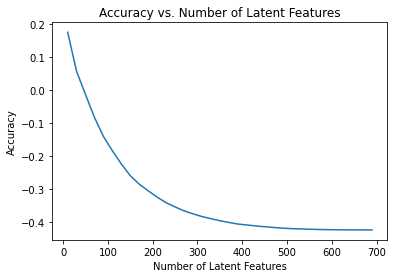

In [2670]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [2764]:
# Train | Test Spilt

df_train = df.iloc[0:40000,:].copy()
df_test = df.iloc[40000:,:].copy()


df_train.article_id = df_train.article_id.astype(int)
df_test.article_id = df_test.article_id.astype(int)

print("Number of instances for training: ", df_train.shape[0])
print("Number of instances for testing: ", df_test.shape[0])

Number of instances for training:  40000
Number of instances for testing:  5993


In [2765]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.to_list()
    test_arts = user_item_test.columns.to_list()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [2767]:
user_item_train

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4483,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4484,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2766]:
user_item_test

article_id,0,2,4,8,9,12,14,15,16,18,...,1432,1433,1434,1435,1436,1437,1439,1440,1441,1443
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2807]:
common_user_item_test=user_item_train[user_item_train.index.isin(user_item_test.index)]
#artcilesid 
common_user_item_test=common_user_item_test.loc[:,user_item_train.columns.isin(user_item_test.columns)]

common_user_item_test.sum(axis=1)

user_id
2917    10
3024    26
3093    13
3193     1
3527     4
3532    20
3684    35
3740    20
3777     1
3801     8
3968    18
3989     1
3990     1
3998     2
4002     1
4204    20
4231     8
4274    16
4293    25
4487    14
dtype: int64

In [3221]:
user_ids_intersected

array([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968,
       3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487])

In [2810]:
# experimenting

users_can_predict = np.intersect1d(list(user_item_train.index),list(user_item_test.index))

users_can_predict

array([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968,
       3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487])

In [2777]:
# Q: 
# How many users can we make predictions for in the test set?': 
# How many users can we make predictions for in the test set?': 
# 
# that means how many intersected users in train that also found in test set.

user_ids_intersected = np.intersect1d(user_item_train.index, user_item_test.index)

number_of_user_ids_intersected = len(user_ids_intersected)
print(number_of_user_ids_intersected)

# Substract the number from number of test. (number of unique users different from train set)
len(test_idx) - number_of_user_ids_intersected

# Users can predict are the intersected / common users in train and test set. 
# (If users that are not in training set, then machine will not have affinity info for them)
# since latent factor applied to users. Since we know these users' affinity, we might know how likely 
# he/she would like to interact each article (even tho he/she not interacted that article before). 



20


662

In [2791]:
# Q:
# How many articles can we make predictions for in the test set?
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
# That means, are article ids that in test set, also appear in train set. Any unique article not found in train set.

article_ids_intersected = np.intersect1d(user_item_train.columns, user_item_test.columns)

np.sum(article_ids_intersected != np.array(user_item_test.columns))

# zero. no unique found. Which means, ids in test set are all also there in train set. all movies in test will 
# have its latent factor. 



0

In [2809]:
user_item_test

article_id,0,2,4,8,9,12,14,15,16,18,...,1432,1433,1434,1435,1436,1437,1439,1440,1441,1443
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2796]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
    }

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


---
`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. 

Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. 

This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [2928]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [2929]:
print(u_train.shape, s_train.shape, vt_train.shape)

print(f"Total users in train set: {u_train.shape[0]}")
print(f"Total articles in train set: {vt_train.shape[0]}")
print(f"Total number of latent factors: {s_train.shape[0]}")

(4487, 4487) (714,) (714, 714)
Total users in train set: 4487
Total articles in train set: 714
Total number of latent factors: 714


In [2917]:
u_new = u_train[:, :len(s_train)]
u_new.shape

(4487, 714)

In [2918]:
# update the shape of s and store in s_new
s_new = np.zeros((len(s_train), len(s_train)))
s_new[:len(s_train), :len(s_train)] = np.diag(s_train) 
s_new.shape

(714, 714)

In [2919]:
vt_new = vt_train
vt_new.shape

(714, 714)

In [2920]:
np.dot(np.dot(u_new, s_new), vt_new).sum(axis=1)

array([36.,  6., 40., ...,  3.,  3., 15.])

In [2921]:
np.array(user_item_train.sum(axis=1))

array([36,  6, 40, ...,  3,  3, 15])

In [2944]:
vt_train[:600].shape

(600, 714)

In [3025]:
def reconstruct(u_train, s_train, vt_train, k=len(s_train)):
    
    
    print(f"[k]: {k}")
    
    u_new = u_train[:, :k]
    
    s_new = np.zeros((k, k))
    s_new[:k, :k] = np.diag(s_train[:k])
    
    vt_new = vt_train[:k, :]
    
    dot_products = np.dot(np.dot(u_new, s_new), vt_new)
    
    return dot_products
    
    
reconstruct(u_train, s_train, vt_train, 710).sum(axis=1)
    


[k]: 710


array([36.,  6., 40., ...,  3.,  3., 15.])

---

In [2827]:
# User ids of those are predictable in test set. (the common users in two sets)

users_predictable = user_ids_intersected
users_predictable

array([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801, 3968,
       3989, 3990, 3998, 4002, 4204, 4231, 4274, 4293, 4487])

---

In [3213]:
from sklearn.metrics import r2_score



#  Rows that match the test set
test_idx = user_item_test.index
row_idxs = user_item_train.index.isin(test_idx)
u_test = u_train[row_idxs, :]


#  Columns that match the test set
test_col = user_item_test.columns
col_idxs = user_item_train.columns.isin(test_col)
vt_test = vt_train[:, col_idxs]

# Test data (reshaping to the subset of those intersected users)
train_idx = user_item_train.index
row_idxs_2 = user_item_test.index.isin(train_idx)
user_item_test_subset = user_item_test.loc[row_idxs_2]



num_latent_feats = np.arange(10,700+10,20)

scores_train = []
scores_test = []


for k in num_latent_feats:
    
    
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    
    # Take dot product to get prediction
    
    # predictions on train set
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    
    # predictions on test set
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    

    # Calculate R2 score with sklearn.metrics.r2_score(y_true, y_pred)
    
    # R2 score as accuracy for train set. (true of train vs pred of train)
    r2s_train_sets = r2_score(user_item_train, user_item_train_preds)
    
    # R2 score as accuracy for test set. (true ot test vs pred of test)
    r2s_test_sets = r2_score(user_item_test_subset, user_item_test_preds)
    
    
    scores_train.append(r2s_train_sets)
    scores_test.append(r2s_test_sets)
    
    
    # print(r2s_train_sets, r2s_test_sets)
    


0.007516754093525902 0.6604198054917303
0.05582851571825394 0.6328017631956505
0.11007778268016816 0.6168364553780433
0.16561571815696632 0.5848351225385319
0.21981865806865664 0.5603945375754067
0.27937356264867874 0.5309917623446467
0.3322637852734185 0.5149353611791314
0.3752365658946877 0.5038755724797407
0.4179165888310912 0.49245474398574146
0.46329130485256803 0.48191008966701776
0.5025390623844941 0.4679728074370526
0.5404423050485289 0.46091247367582017
0.5811492088746872 0.4503678193570966
0.6171027979107029 0.4433074855958643
0.643502954189826 0.4378976194671278
0.6678385930007024 0.4309289783521452
0.6982067468163089 0.4309289783521452
0.7221670545560043 0.42744465779465396
0.7470141484284704 0.42744465779465396
0.7799326215735457 0.42396033723716264
0.7999294739708878 0.42396033723716264
0.8196544380706139 0.42396033723716264
0.8360005380978012 0.42396033723716264
0.8582465833381127 0.42396033723716264
0.8778089868944815 0.42396033723716264
0.8927366188987824 0.42396033723

<AxesSubplot:>

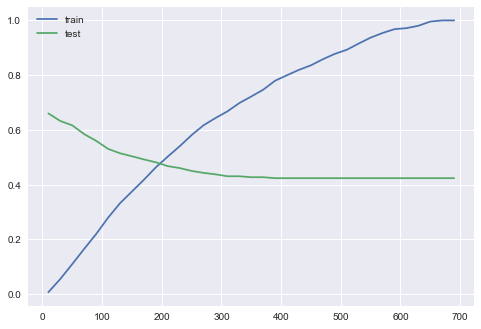

In [3212]:
# Plotting

df_scores = pd.DataFrame({
   'train': scores_train,
   'test': scores_test
   }, index=num_latent_feats)

df_scores.plot.line()

### Intepreting the plot:
- As we can see, while the k (number of latent factors) increases, the accuracy imporves, the amount of data points benefit the model, the latent factors / affinity gets more accurate. 
- In contrast, for the test set, in test set predict simulation, the accuracy get wrose when increase number of latent factors. This is possible due to very limited of data points (20 instances) in test set. The more factors, the more overfitted, make it even more less predictable.
